In [ ]:
# Good resources
# https://colab.research.google.com/github/deepmind/deepmind-research/blob/master/polygen/training.ipynb
# https://towardsdatascience.com/generating-3d-models-with-polygen-and-pytorch-4895f3f61a2e

# https://pytorch3d.org/tutorials/render_textured_meshes

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt

import torch
# import vtk
# from vedo import *



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive

/content/drive/MyDrive


In [ ]:
# ! git clone https://github.com/RobertSmithers/3DTeethSegmentation.git

Cloning into '3DTeethSegmentation'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 33 (delta 9), reused 4 (delta 1), pack-reused 0
Unpacking objects: 100% (33/33), done.


In [ ]:
# !rm -rf /content/Images

In [2]:
!mkdir d/

In [4]:
###Unzip DATA###

#Before run the code section, manually upload data to the file space / work space
!unzip /content/original_img.zip -d /content/d
!unzip /content/masked_img.zip -d /content/d

Archive:  /content/original_img.zip
   creating: /content/d/Images/
 extracting: /content/d/Images/1.png  
 extracting: /content/d/Images/10.png  
 extracting: /content/d/Images/100.png  
 extracting: /content/d/Images/101.png  
 extracting: /content/d/Images/102.png  
 extracting: /content/d/Images/103.png  
 extracting: /content/d/Images/104.png  
 extracting: /content/d/Images/105.png  
 extracting: /content/d/Images/106.png  
 extracting: /content/d/Images/107.png  
 extracting: /content/d/Images/108.png  
 extracting: /content/d/Images/109.png  
 extracting: /content/d/Images/11.png  
 extracting: /content/d/Images/110.png  
 extracting: /content/d/Images/111.png  
 extracting: /content/d/Images/112.png  
 extracting: /content/d/Images/113.png  
 extracting: /content/d/Images/114.png  
 extracting: /content/d/Images/115.png  
 extracting: /content/d/Images/116.png  
 extracting: /content/d/Images/12.png  
 extracting: /content/d/Images/13.png  
 extracting: /content/d/Images/14.pn

In [5]:
# from numpy.core.fromnumeric import size
###Pre-Process DATA###
from PIL import Image
def convert_one_channel(img):
    #some images have 3 channels , although they are grayscale image
    if len(img.shape)>2:
        img=img[:,:,0]
        return img
    else:
        return img

def pre_images(resize_shape,path):
    # dirs=os.listdir(path)
    # print(dirs)
    # sizes=np.zeros([len(dirs),2])
    # img=Image.open(path+dirs[0])
    # sizes[0,:]=images.size
    # images=(img.resize((resize_shape),Image.ANTIALIAS))
    # images=convert_one_channel(np.asarray(images))
    # print(images.shape)
    # for i in range (1,len(dirs)):
    # newsize=(1024,1024)
    img=Image.open(path)
      # print(img.size)
    img=img.resize((resize_shape),Image.ANTIALIAS)
    img=convert_one_channel(np.asarray(img))
    # print(img.size)
    # images=np.reshape(images,(len(dirs),resize_shape[0],resize_shape[1],1))
    return img

# res=pre_images((512,512),'/content/d/Images/')
# ress=Image.open('/content/d/masked_img/1.png')
# img=ress.resize((1024,512), Image.ANTIALIAS)
# plt.imshow(img)

In [ ]:
# for index in range(116):
#     file_path = os.path.join('/content/pset4/training_set', train_pixel_file.iloc[index, 0].replace('.png','_resize.png'))
#     image = cv2.imread(file_path)
#     cv2.imwrite(file_path, mask)

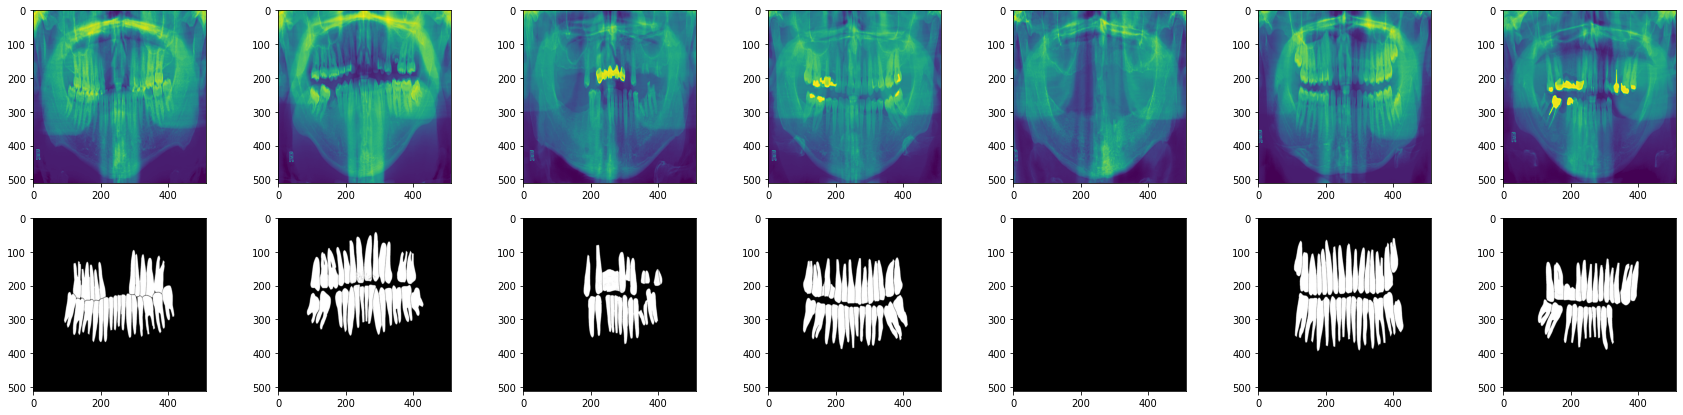

In [6]:
fig = plt.figure(figsize = (30,7))
for index in range(7):
  file_path1 = os.path.join('/content/d/Images', str(index+1)+'.png')
  file_path2 = os.path.join('/content/d/masked_img', str(index+1)+'.png')
  # print(file_path)
  ax = fig.add_subplot(2, 7, index+1) 
  plt.imshow(pre_images((512,512),file_path1))  #show result of converting every img to one color channel
    
  ax = fig.add_subplot(2, 7, index+8)
  plt.imshow(cv2.imread(file_path2))

In [7]:
from sklearn.model_selection import train_test_split

from skimage import io, color

import random

from torch.utils.data  import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [9]:
arr1=np.arange(1,117)
print(arr1)
df=pd.DataFrame(arr1)
df.to_csv('sample.csv')

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116]


In [11]:
root_dir='/content/d'
print(os.path.join(root_dir, 'Images',.iloc[index, 0]))

/content/d/Images


In [39]:
###Load DATA

# our dataset class
rest_set_size = 0.3
test_set_size = 0.5
class dset(Dataset):
    def __init__(self, root_dir, train=True,test=True,transformX = None, transformY = None):
        self.pixel_file = pd.read_csv(os.path.join(root_dir, 'sample.csv'))
        self.root_dir = root_dir
        self.transformX = transformX
        self.transformY = transformY
        self.train = train
        self.test = test
        
        # split the dataset to train and rest
        # split the rest to validation and test
        self.train_data, self.rest_data = train_test_split(self.pixel_file, test_size = rest_set_size, random_state = 5)
        # print(len(self.rest_data))
        self.validation_data, self.test_data = train_test_split(self.rest_data, test_size = test_set_size, random_state = 5)
        # print(len(self.validation_data))

    def __len__(self):
        if self.train:
          length = len(self.train_data)
        elif self.test:
          length = len(self.test_data)
        else:
          length = len(self.validation_data)
        return length
    
    def __getitem__(self, index):
        if self.train:
          imx_name = os.path.join(self.root_dir, 'Images',self.train_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'masked_img',self.train_data.iloc[index, 0])
        elif self.test:
          imx_name = os.path.join(self.root_dir, 'Images',self.test_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'masked_img',self.test_data.iloc[index, 0])
        else:
          imx_name = os.path.join(self.root_dir, 'Images', self.validation_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'masked_img',self.validation_data.iloc[index, 0])
        
        imx = Image.open(imx_name)
        imy = Image.open(imy_name).convert('L')

        if self.transformX:
            imx = self.transformX(imx)
            imy = self.transformY(imy)
      
        sample = {'image': imx, 'annotation': imy}
        return sample

In [40]:
tx_X = transforms.Compose([ transforms.Resize((512, 512)),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))
                              ])
tx_Y = transforms.Compose([ transforms.Resize((512, 512)),
                              transforms.ToTensor()
                              ])
train_data = dset('/content/', train = True, test=False, transformX = tx_X, transformY = tx_Y)
validation_data = dset('/content/', train = False,test=False,transformX = tx_X, transformY = tx_Y)
test_data = dset('/content/', train = False, test=True,transformX = tx_X, transformY = tx_Y)

train_loader = DataLoader(dataset=train_data, batch_size=2, shuffle=False, num_workers=2)
validation_loader = DataLoader(dataset=validation_data, batch_size=2, shuffle=False, num_workers=2)

In [42]:
print(len(train_data))
print(len(validation_data))
print(len(test_data))

81
17
18
